In [122]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from scipy.linalg import fractional_matrix_power

In [43]:
# build the ingredient list

node_labels = {}

for i, line in enumerate(open('data/node-labels.txt')):
    node_labels[i] = line.strip()
    
len(node_labels)

6714

In [44]:
hyperedge_map_dict = {}

# get edge category labels
for i, line in enumerate(open('data/hyperedge-label-identities.txt')):
    hyperedge_map_dict[i+1] = line.strip()    
    
edge_labels = {}

for i, line in enumerate(open('data/hyperedge-labels.txt')):
    edge_labels[i] = hyperedge_map_dict[int(line.strip())]

len(edge_labels)

39774

In [45]:
edges = {}

for i, line in enumerate(open('data/hyperedges.txt')):
    edges[i] = [int(x.strip()) for x in line.split("\t")]

print(len(edges))

39774


In [81]:
%%time
"""build the hypergraph incidence matrix"""

raw_df = pd.DataFrame(node_labels.items(), 
                  columns=['node_id', 'node_name'])


for i, item in enumerate(edges.items()):
    raw_df[i+1] = np.where(raw_df['node_id'].isin(item[1]), 1, 0)

print(raw_df.shape)
raw_df.head()

<timed exec>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


(6714, 39776)
CPU times: user 55.2 s, sys: 947 ms, total: 56.1 s
Wall time: 56.2 s


,node_id,node_name,1,2,3,4,5,6,7,8,...,39765,39766,39767,39768,39769,39770,39771,39772,39773,39774
0,0,ginger paste,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,sea salt,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,shortbread,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,3,chocolate,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,puffed rice,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [90]:
list(edges.keys())[:10]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [95]:
""" define a toy subset """

N_COLS = 100

hyperedges = np.random.choice(list(edges.keys()), N_COLS)

cols = ['node_id', 'node_name'] + list(hyperedges)

df = raw_df[cols]

df['row_sum'] = df[hyperedges].sum(axis=1)

print(df.shape)
df = df[df['row_sum'] > 0]
print(df.shape)

df.head()
# df.to_csv("paovis.csv", index=False)

(6714, 103)
(513, 103)


/home/cstansbu/.local/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,node_id,node_name,28930,9420,3178,10120,39466,39250,3509,33324,...,29331,26930,36871,27276,37403,7845,12783,27502,12428,row_sum
2,2,shortbread,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
13,13,coke zero,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
20,20,fingerling potatoes,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,15
32,32,reduced sodium tamari,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,3
41,41,sour salt,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [137]:
"""construct L"""

I = np.eye(len(df))
Hh = df[hyperedges].to_numpy()

# construct D^-1/2
Dh = np.zeros((len(df), len(df)))
np.fill_diagonal(Dh, df['row_sum'])
D_inv_sq = fractional_matrix_power(Dh, -0.5)
De = np.zeros((len(hyperedges), len(hyperedges)))
cardinalities = df[hyperedges].sum().to_numpy()
np.fill_diagonal(De, cardinalities)


Lh1 = np.matmul(D_inv_sq, Hh)
Lh2 = np.matmul(Lh1, np.linalg.inv(De))
Lh3 = np.matmul(Lh2, Hh.T)
Lh = I - np.matmul(Lh3, D_inv_sq)

print(Lh1.shape)
print(Lh2.shape)
print(Lh3.shape)
print(Lh.shape)

(513, 100)
(513, 100)
(513, 513)
(513, 513)


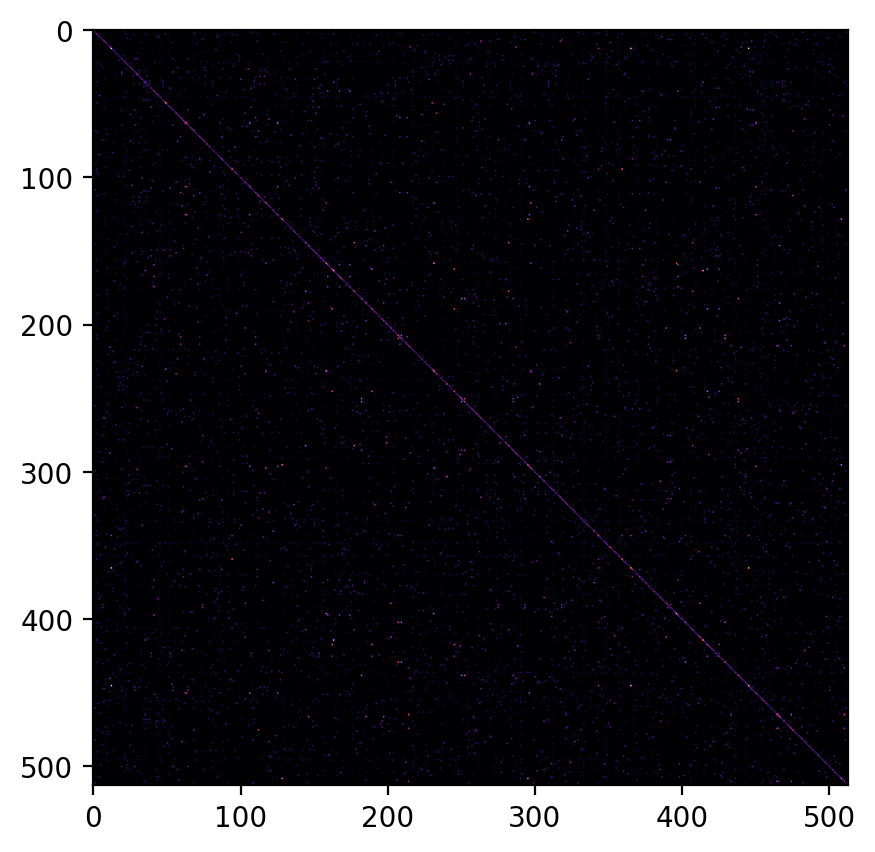

In [138]:
plt.imshow(Lh, cmap='inferno')

13

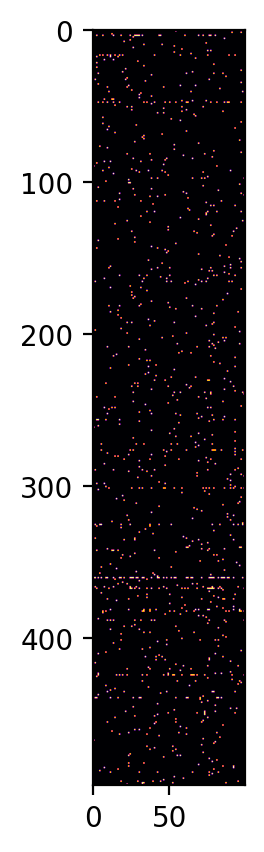

In [94]:
im = df[hyperedges].to_numpy()

matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams['figure.figsize'] = (5, 5)
plt.imshow(im, cmap='inferno')